In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

import darts
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score, mae
from darts.utils.statistics import check_seasonality, plot_acf, extract_trend_and_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
## load data

ccs = pd.read_csv('your path',parse_dates=["Time"], low_memory=False)

In [4]:
ccs = ccs[['Time','Direction', 'Volume']]

In [5]:
ccs = ccs.loc[ccs['Direction']=='S']
ccs

,Time,Direction,Volume
1,2018-08-01 00:00:00,S,149
3,2018-08-01 00:05:00,S,141
5,2018-08-01 00:10:00,S,133
7,2018-08-01 00:15:00,S,160
9,2018-08-01 00:20:00,S,112
...,...,...,...
420469,2020-07-31 23:35:00,S,205
420471,2020-07-31 23:40:00,S,195
420473,2020-07-31 23:45:00,S,180
420475,2020-07-31 23:50:00,S,168


In [6]:
vds = pd.read_csv(r'your path')
vds2 = pd.read_csv(r'your path')

In [7]:
vds = vds.groupby(['datestamp','timestamp']).sum().reset_index()
vds = vds.rename(columns={'datestamp': 'Date','timestamp':'Time','det_vol': 'VolumeVDS'})
vds = vds[['Date','Time','VolumeVDS']]
vds2 = vds2.groupby(['datestamp','timestamp']).sum().reset_index()
vds2 = vds2.rename(columns={'datestamp': 'Date','timestamp':'Time','det_vol': 'VolumeVDS2'})
vds2 = vds2[['Date','Time','VolumeVDS2']]

In [8]:
vds.head(10)

,Date,Time,VolumeVDS
0,1/1/2018,00:00,68
1,1/1/2018,00:05,69
2,1/1/2018,00:10,82
3,1/1/2018,00:15,102
4,1/1/2018,00:20,92
5,1/1/2018,00:25,80
6,1/1/2018,00:30,92
7,1/1/2018,00:35,87
8,1/1/2018,00:40,83
9,1/1/2018,00:45,69


In [9]:
ccs = ccs.dropna(subset=['Volume'])
ccs['date_time']=pd.to_datetime(ccs['Time']) 
ccs=ccs.loc[:,['date_time','Volume']]
ccs.sort_values('date_time', inplace=True, ascending=True)
ccs = ccs.reset_index(drop=True)
print('Number of rows and columns after removing missing values:', ccs.shape)
print('The time series starts from: ', ccs.date_time.min())
print('The time series ends on: ', ccs.date_time.max())

Number of rows and columns after removing missing values: (210239, 2)
The time series starts from:  2018-08-01 00:00:00
The time series ends on:  2020-07-31 23:55:00


In [10]:
vds['date_time'] = pd.to_datetime(vds['Date'] + ' ' + vds['Time'])
vds = vds.dropna(subset=['VolumeVDS'])
vds['date_time']=pd.to_datetime(vds['date_time'])
vds=vds.loc[:,['date_time','VolumeVDS']]
vds.sort_values('date_time', inplace=True, ascending=True)
vds = vds.reset_index(drop=True)
print('Number of rows and columns after removing missing values:', vds.shape)
print('The time series starts from: ', vds.date_time.min())
print('The time series ends on: ', vds.date_time.max())

Number of rows and columns after removing missing values: (479286, 2)
The time series starts from:  2017-06-01 13:45:00
The time series ends on:  2022-01-01 14:40:00


In [11]:
vds2['date_time'] = pd.to_datetime(vds2['Date'] + ' ' + vds2['Time'])
vds2 = vds2.dropna(subset=['VolumeVDS2'])
vds2['date_time']=pd.to_datetime(vds2['date_time']) 
vds2=vds2.loc[:,['date_time','VolumeVDS2']]
vds2.sort_values('date_time', inplace=True, ascending=True)
vds2 = vds2.reset_index(drop=True)
print('Number of rows and columns after removing missing values:', vds2.shape)
print('The time series starts from: ', vds2.date_time.min())
print('The time series ends on: ', vds2.date_time.max())

Number of rows and columns after removing missing values: (499732, 2)
The time series starts from:  2017-01-01 13:45:00
The time series ends on:  2022-01-01 14:40:00


In [12]:
vds2['VolumeVDS2'] = vds2["VolumeVDS2"].round().astype(int)

In [13]:
df = ccs.merge(vds, how='left', on='date_time')
df

,date_time,Volume,VolumeVDS
0,2018-08-01 00:00:00,149,73.0
1,2018-08-01 00:05:00,141,70.0
2,2018-08-01 00:10:00,133,128.0
3,2018-08-01 00:15:00,160,89.0
4,2018-08-01 00:20:00,112,112.0
...,...,...,...
210234,2020-07-31 23:35:00,205,132.0
210235,2020-07-31 23:40:00,195,130.0
210236,2020-07-31 23:45:00,180,107.0
210237,2020-07-31 23:50:00,168,87.0


In [14]:
df = df.merge(vds2, how='left', on='date_time')
df

,date_time,Volume,VolumeVDS,VolumeVDS2
0,2018-08-01 00:00:00,149,73.0,99.0
1,2018-08-01 00:05:00,141,70.0,113.0
2,2018-08-01 00:10:00,133,128.0,106.0
3,2018-08-01 00:15:00,160,89.0,103.0
4,2018-08-01 00:20:00,112,112.0,97.0
...,...,...,...,...
210234,2020-07-31 23:35:00,205,132.0,153.0
210235,2020-07-31 23:40:00,195,130.0,149.0
210236,2020-07-31 23:45:00,180,107.0,124.0
210237,2020-07-31 23:50:00,168,87.0,126.0


In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
ccscaler = MinMaxScaler()
vdscaler = MinMaxScaler()
vds2scaler = MinMaxScaler()

In [17]:
df['Volume'] = ccscaler.fit_transform(df[['Volume']])
df['VolumeVDS'] = vdscaler.fit_transform(df[['VolumeVDS']])
df['VolumeVDS2'] = vds2scaler.fit_transform(df[['VolumeVDS2']])

In [19]:
df['Volume'].isnull().values.any()

False

In [19]:
seriesccs = TimeSeries.from_dataframe(df, 'date_time','Volume', fill_missing_dates=True, freq=None)
seriesvds = TimeSeries.from_dataframe(df, 'date_time', value_cols=['VolumeVDS', 'VolumeVDS2'], fill_missing_dates=True, freq=None)

In [20]:
seriesvds = fill_missing_values(seriesvds, fill='auto')
seriesccs = fill_missing_values(seriesccs, fill='auto')

In [21]:
ccs_train, ccs_test = seriesccs.split_before(0.8)
vds_train, vds_test = seriesvds.split_before(0.8)

In [ ]:
# ccs_test = fill_missing_values(ccs_test, fill='auto')
# ccs_train = fill_missing_values(ccs_train, fill='auto')
# vds_test = fill_missing_values(vds_test, fill='auto')
# vds_train = fill_missing_values(vds_train, fill='auto')

In [22]:
print(missing_values_ratio(vds_test))
print(missing_values_ratio(vds_train))
print(missing_values_ratio(ccs_train))
print(missing_values_ratio(ccs_test))
# print(missing_values_ratio(ccs_val))
# print(missing_values_ratio(vds_val))

0.0
0.0
0.0
0.0


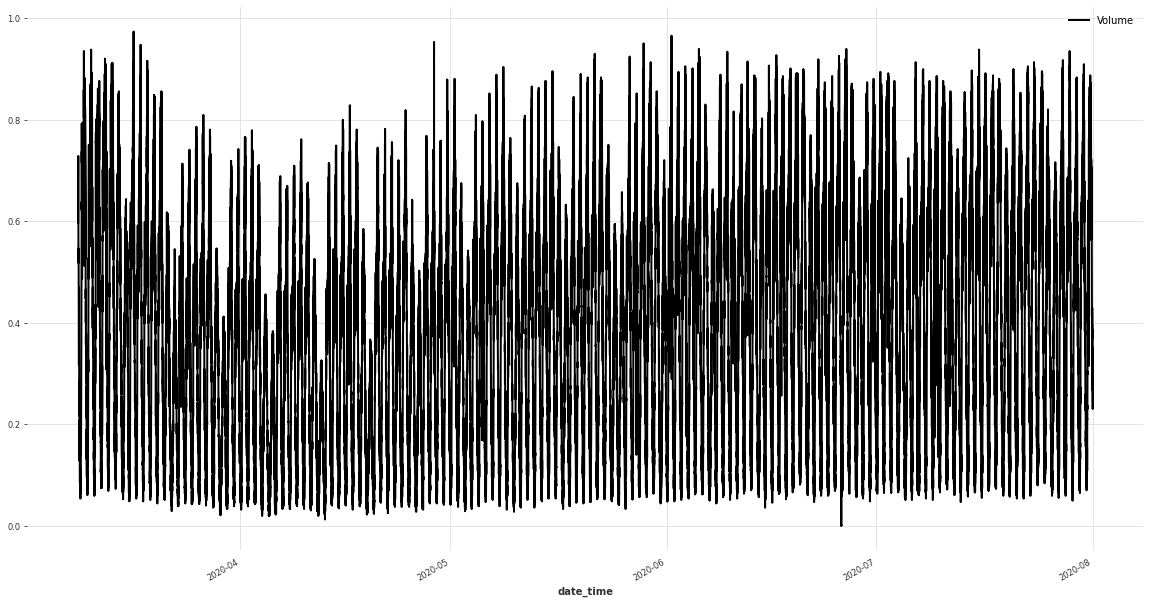

In [61]:
# plot the observations
plt.figure(100, figsize=(20, 10))
# vds_test[:-288].plot()
# seriesccs.plot()
# testvds.plot()
ccs_test[288:].plot()
# ccs_train.plot()

# seriesccs[-len(ccs_test)-100:].plot()
# ccs_test[-288*3:].plot()
# plt.savefig('CCS and VDS plotted.pdf')

In [62]:
#function to eval whicever model we decide to run

def eval(model, n=input, series=None, past_covariates=None, future_covariates=None, file_name=input):
#past and future covariates set to none because they can be optional and I wanted to test without them
    
    #backtest model on last 20% (test set) with horizon of 288*2 steps (2 whole days)
    pred = model.predict(n=n,
                         series=series,
                          past_covariates=past_covariates,
                          future_covariates=future_covariates,
                          n_jobs=2,
                          verbose=True
                         )
    
    plt.figure(figsize=(20, 10))
    plt.title('{} Plot'.format(file_name), fontsize=14, fontweight='bold')

    ccs_test[-288*3:].plot(label='Actual Values, last 3 days')
    pred[-288*3:].plot(label='Forecasted Model Values, last 3 days')
    plt.savefig('{} model eval.pdf'.format(file_name))
    print('Test RMSE = {}'.format(rmse(ccs_test, pred)))
    print('Test MAE = {}'.format(mae(ccs_test, pred)))

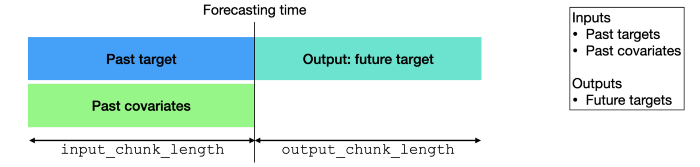

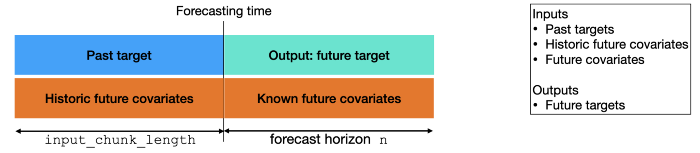

In [25]:
from darts.models import RNNModel, BlockRNNModel, TCNModel, NBEATSModel, TransformerModel, RegressionModel, TFTModel

#All these models suppot past covariates
#Only RNNModel and RegressionModel support future covariates

# LSTM Model

In [26]:
LSTM = BlockRNNModel(input_chunk_length=288,
                     output_chunk_length=288,
                     n_epochs=100,
                     batch_size=320,
                     model='LSTM',
                     optimizer_kwargs={
                         "lr": .001},
                     pl_trainer_kwargs={
                        "accelerator": "gpu",
                        "gpus": [0]}
                           )

In [29]:
LSTM.fit(series=ccs_train,
         past_covariates=vds_train,
         verbose=True,
         num_loader_workers=2
        )

2022-11-01 20:28:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-01 20:28:48 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-01 20:28:48 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-01 20:28:48 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-01 20:28:52 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-01 20:28:52 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.0 K 
4 | fc            | Sequential       | 7.5 K 
---------------------------------------------------
10.5 K    Trainable params
0         No

Training: 0it [00:00, ?it/s]

2022-11-01 21:41:14 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


2022-11-02 14:04:44 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

Test RMSE = 0.17394049996382913
Test MAE = 0.1308529368843319


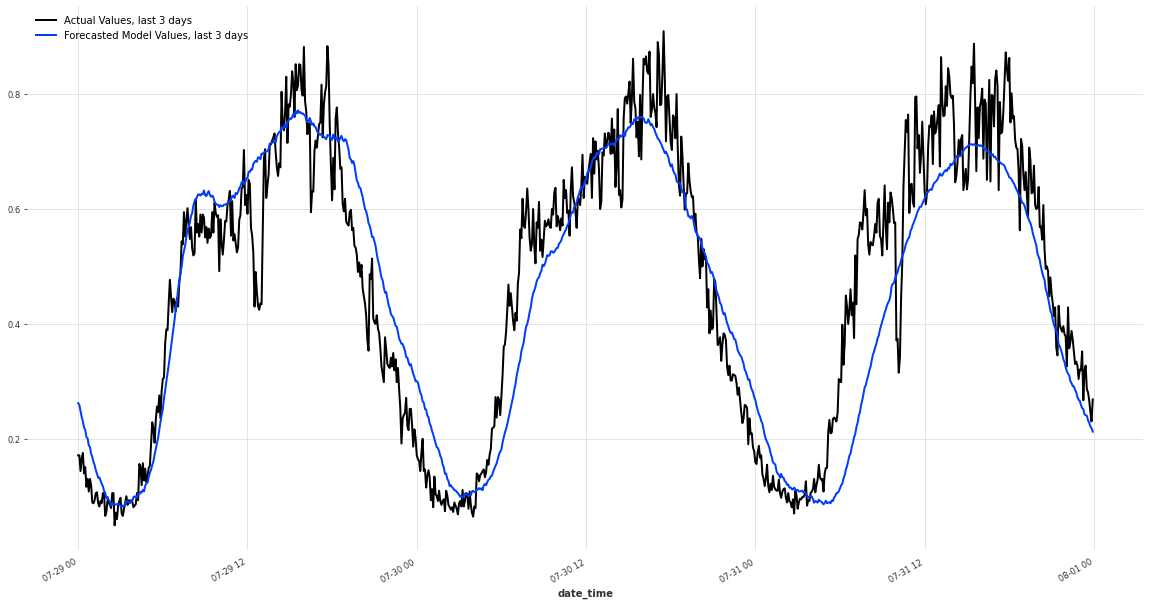

In [63]:
eval(LSTM, n=len(ccs_test), past_covariates=seriesvds, file_name='LSTM')

# TCN Model

In [27]:
TCN = TCNModel(
        input_chunk_length=289, #FC_N+1,
        output_chunk_length=288, #FC_N, 
        n_epochs=100,
        batch_size=320,
        optimizer_kwargs={'lr': .001},
        pl_trainer_kwargs={
          "accelerator": "gpu",
          "gpus": [0]
        }
    )

In [32]:
TCN.fit(series=ccs_train,
              past_covariates=vds_train,
              verbose=True,
              num_loader_workers=2
        )

2022-11-01 21:44:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-01 21:44:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-01 21:44:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-01 21:44:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-01 21:44:04 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-01 21:44:04 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 404   
----------------------------------------------------
404       Trainable params
0   

Training: 0it [00:00, ?it/s]

2022-11-01 22:19:47 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


2022-11-02 14:09:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

Test RMSE = 0.10893041478700251
Test MAE = 0.0832884094476642


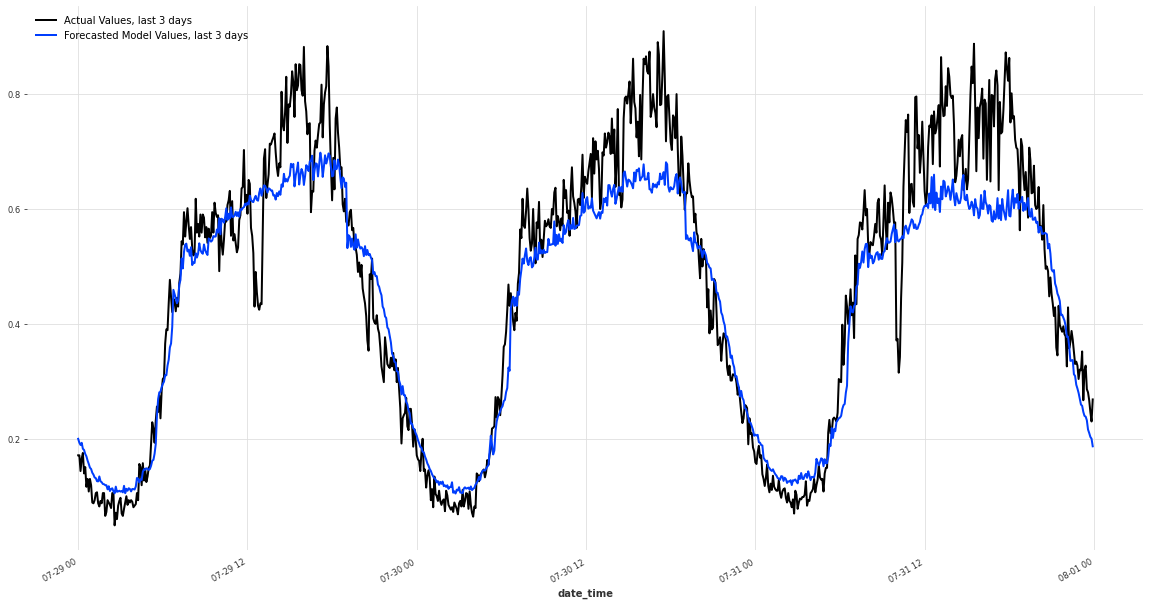

In [64]:
eval(TCN, n=len(ccs_test), past_covariates=seriesvds, file_name='TCN')

# GRU Model

In [28]:
GRU = BlockRNNModel(input_chunk_length=288,
                     output_chunk_length=288,
                     n_epochs=100,
                     batch_size=320,
                     model='GRU',
                     optimizer_kwargs={
                         "lr": .001},
                     pl_trainer_kwargs={
                        "accelerator": "gpu",
                        "gpus": [0]}
                           )

In [34]:
GRU.fit(series=ccs_train,
         past_covariates=vds_train,
         verbose=True,
         num_loader_workers=2
        )

2022-11-01 22:21:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-01 22:21:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-01 22:21:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-01 22:21:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-01 22:21:59 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-01 22:21:59 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 2.2 K 
4 | fc            | Sequential       | 7.5 K 
---------------------------------------------------
9.7 K     Trainable params
0         No

Training: 0it [00:00, ?it/s]

2022-11-01 23:30:27 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


2022-11-02 14:10:07 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

Test RMSE = 0.17737195568107797
Test MAE = 0.13505301822342197


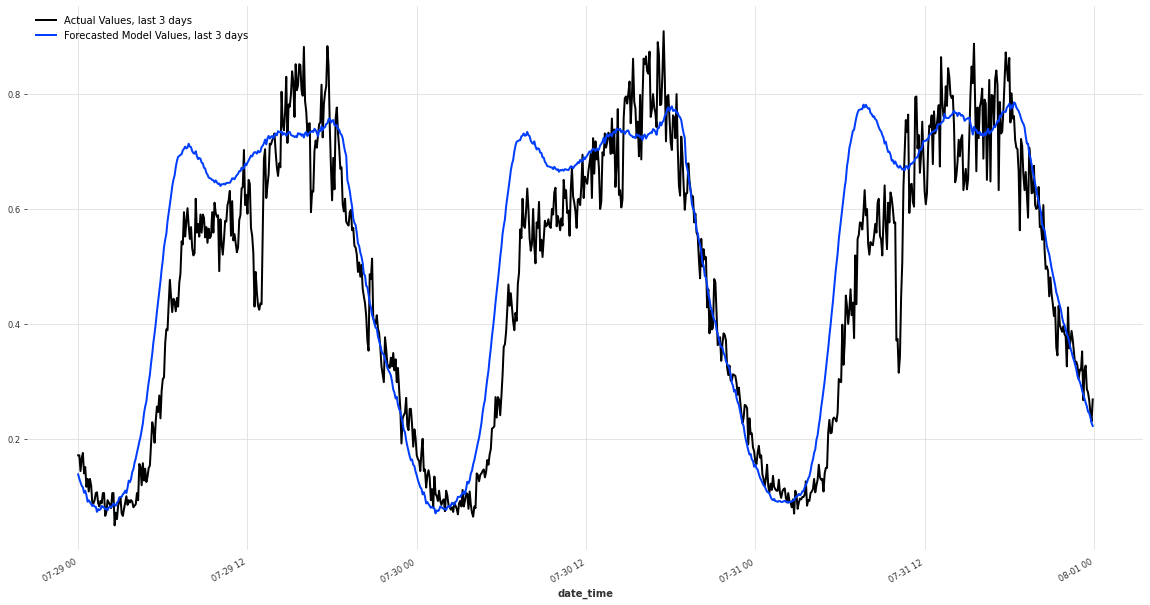

In [66]:
eval(GRU, n=len(ccs_test), past_covariates=seriesvds, file_name='GRU')

In [81]:
#function to eval whicever model we decide to run

def plotmodels(n=input, series=None, past_covariates=None, future_covariates=None, file_name=input):
#past and future covariates set to none because they can be optional and I wanted to test without them
    
    #backtest model on last 20% (test set) with horizon of 288*2 steps (2 whole days)
    pred1 = LSTM.predict(n=n,
                         series=series,
                          past_covariates=past_covariates,
                          future_covariates=future_covariates,
                          n_jobs=2,
                          verbose=True
                         )
    
    pred2 = GRU.predict(n=n,
                         series=series,
                          past_covariates=past_covariates,
                          future_covariates=future_covariates,
                          n_jobs=2,
                          verbose=True
                         )
    
    pred3 = TCN.predict(n=n,
                         series=series,
                          past_covariates=past_covariates,
                          future_covariates=future_covariates,
                          n_jobs=2,
                          verbose=True
                         )
    
    plt.figure(figsize=(25, 12))
    plt.title('{} Plot'.format(file_name), fontsize=14, fontweight='bold')

    ccs_test[-288*3:].plot(label='Actual Values, last 3 days')
    pred1[-288*3:].plot(label='Forecasted LSTM Values, last 3 days', color='red')
    pred2[-288*3:].plot(label='Forecasted GRU Values, last 3 days', color='green')
    pred3[-288*3:].plot(label='Forecasted TCN Values, last 3 days', color='blue')
    plt.savefig('{} model eval.pdf'.format(file_name))

2022-11-03 22:10:40 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

2022-11-03 22:10:41 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

2022-11-03 22:10:41 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 525it [00:00, ?it/s]

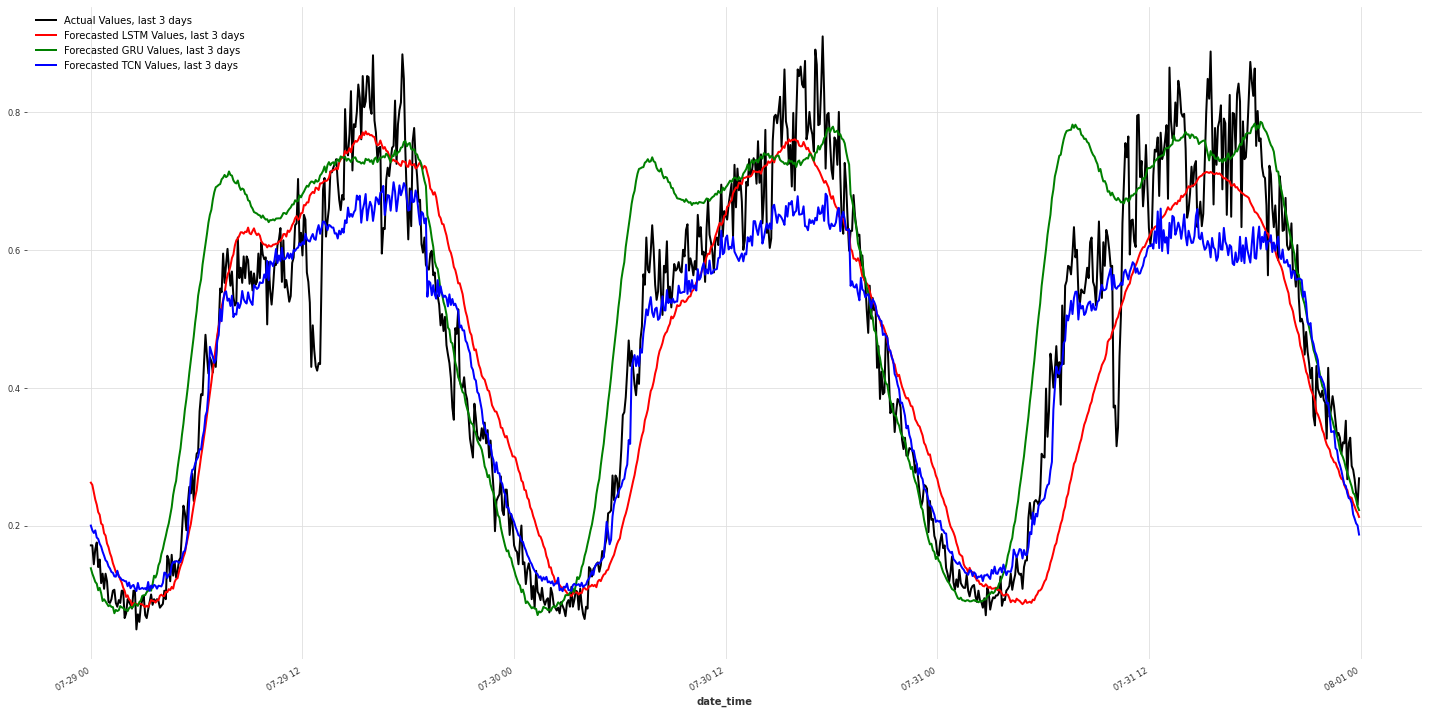

In [82]:
plotmodels(n=len(ccs_test), past_covariates=seriesvds, file_name='All')